In [27]:
import os
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("TF version:", tf.__version__)

H5_PATH = "Data/data_burgers_ref.h5"   # adjust if needed

# Coarse-grid settings for training/evaluation
N_COARSE = 100                         # choose 128/256/512
CFL = 0.25                             
SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

TF version: 2.18.0


In [28]:
class NeuralFlux(tf.keras.Model):
    """
    Consistent numerical flux for inviscid Burgers part:
      f_theta = 0.5*(f(uL)+f(uR)) + (uR-uL)*phi_theta(uL,uR,logmu)
    """
    def __init__(self, hidden_sizes=(64, 64), activation="tanh"):
        super().__init__()
        layers = []
        for h in hidden_sizes:
            layers.append(tf.keras.layers.Dense(h, activation=activation))
        layers.append(tf.keras.layers.Dense(1, activation=None))
        self.net = tf.keras.Sequential(layers)

    @staticmethod
    def physical_flux(u):
        return 0.5 * tf.square(u)

    def call(self, X):
        # X: (batch,3) columns: [uL,uR,log(mu)]
        uL = X[:, 0:1]
        uR = X[:, 1:2]
        log_mu = X[:, 2:3]
        phi = self.net(tf.concat([uL, uR, log_mu], axis=1))
        fL = self.physical_flux(uL)
        fR = self.physical_flux(uR)
        return 0.5*(fL + fR) + (uR - uL)*phi


model = NeuralFlux(hidden_sizes=(128, 128), activation="tanh")
optimizer = tf.keras.optimizers.Adam(1e-3)


In [29]:
def block_average_1d(u_fine, N_coarse):
    """
    u_fine: (N_fine,) numpy array, N_fine divisible by N_coarse
    returns: (N_coarse,)
    """
    N_fine = u_fine.shape[0]
    assert N_fine % N_coarse == 0
    r = N_fine // N_coarse
    return u_fine.reshape(N_coarse, r).mean(axis=1)

@tf.function
def laplacian_periodic_tf(u, dx):
    return (tf.roll(u, shift=-1, axis=0) - 2.0*u + tf.roll(u, shift=1, axis=0)) / (dx*dx)

@tf.function
def flux_divergence_tf(u, dx, mu, model):
    """
    u: (N,) float32
    Computes (F_{i+1/2} - F_{i-1/2})/dx with periodic BC.
    """
    uL = u
    uR = tf.roll(u, shift=-1, axis=0)
    log_mu = tf.fill([tf.shape(u)[0]], tf.math.log(mu))
    X = tf.stack([uL, uR, log_mu], axis=1)  # (N,3)
    F_iphalf = tf.squeeze(model(X), axis=1)  # (N,)
    F_imhalf = tf.roll(F_iphalf, shift=1, axis=0)
    return (F_iphalf - F_imhalf) / dx


In [30]:
def load_coarse_cases(h5_path, N_coarse, max_cases=None):
    cases_data = []
    with h5py.File(h5_path, "r") as f:
        case_names = sorted(list(f["cases"].keys()))
        if max_cases is not None:
            case_names = case_names[:max_cases]

        for name in case_names:
            g = f["cases"][name]
            x_f = g["x"][:]
            times = g["times"][:]
            U = g["U"][:]              # (Nt, N_fine)
            mu = float(g.attrs["mu"])

            N_fine = x_f.shape[0]
            assert N_fine % N_coarse == 0

            # coarse grid
            a, b = x_f.min(), x_f.max()
            x_c = np.linspace(a, b, N_coarse, endpoint=False)
            dx_c = float(x_c[1] - x_c[0])

            Uc = np.stack([block_average_1d(U[n], N_coarse) for n in range(U.shape[0])], axis=0)  # (Nt,Nc)

            cases_data.append({
                "name": name,
                "x": x_c.astype(np.float32),
                "dx": np.float32(dx_c),
                "times": times.astype(np.float32),
                "U": Uc.astype(np.float32),
                "mu": np.float32(mu),
            })
    return cases_data

cases = load_coarse_cases(H5_PATH, N_COARSE, max_cases=None)
print("Loaded coarse cases:", len(cases))
print("Example:", cases[0]["name"], "U shape:", cases[0]["U"].shape, "mu:", cases[0]["mu"])


Loaded coarse cases: 256
Example: case_00000 U shape: (43, 100) mu: 0.018789852


In [31]:
@tf.function
def residual_on_reference_loss(u_n, u_np1, dt, dx, mu, model):
    """
    u_n, u_np1: (N,) float32 tensors (coarse reference states at consecutive saved times)
    """
    du_dt = (u_np1 - u_n) / dt
    flux_div = flux_divergence_tf(u_n, dx, mu, model)
    lap = laplacian_periodic_tf(u_n, dx)
    res = du_dt + flux_div - mu * lap
    return tf.reduce_mean(tf.square(res))


@tf.function
def phase4_train_step(u_n, u_np1, dt, dx, mu, model, optimizer,
                      w_res=1.0, w_cons=1e-2, w_grad=1e-4):
    with tf.GradientTape(persistent=True) as tape:
        # Residual-on-reference
        Lres = residual_on_reference_loss(u_n, u_np1, dt, dx, mu, model)

        # Consistency regularizer: f_theta(u,u,mu) ~= f(u)
        log_mu = tf.fill([tf.shape(u_n)[0]], tf.math.log(mu))
        Xc = tf.stack([u_n, u_n, log_mu], axis=1)
        f_cons = tf.squeeze(model(Xc), axis=1)
        f_phys = 0.5 * tf.square(u_n)
        Lcons = tf.reduce_mean(tf.square(f_cons - f_phys))

        # Smoothness penalty: ||∂f/∂X||^2 on interface samples from u_n
        uL = u_n
        uR = tf.roll(u_n, shift=-1, axis=0)
        X = tf.stack([uL, uR, log_mu], axis=1)
        tape.watch(X)
        fhat = model(X)
        grads = tape.gradient(fhat, X)
        Lgrad = tf.reduce_mean(tf.square(grads))

        loss = w_res*Lres + w_cons*Lcons + w_grad*Lgrad

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, Lres, Lcons, Lgrad


In [32]:
def sample_batch_phase4(cases):
    # choose case and time index uniformly
    c = np.random.randint(0, len(cases))
    data = cases[c]
    U = data["U"]
    times = data["times"]
    n = np.random.randint(0, U.shape[0]-1)

    u_n = tf.convert_to_tensor(U[n], dtype=tf.float32)
    u_np1 = tf.convert_to_tensor(U[n+1], dtype=tf.float32)
    dt = tf.convert_to_tensor(times[n+1] - times[n], dtype=tf.float32)
    dx = tf.convert_to_tensor(data["dx"], dtype=tf.float32)
    mu = tf.convert_to_tensor(data["mu"], dtype=tf.float32)
    return u_n, u_np1, dt, dx, mu, data["name"], float(times[n])

# Train
EPOCHS = 10_000
print_every = 200

for step in range(1, EPOCHS+1):
    u_n, u_np1, dt, dx, mu, name, t0 = sample_batch_phase4(cases)
    loss, Lres, Lcons, Lgrad = phase4_train_step(
        u_n, u_np1, dt, dx, mu, model, optimizer,
        w_res=1.0, w_cons=1e-2, w_grad=1e-4
    )

    if step % print_every == 0:
        print(f"[Phase4] step={step:06d} case={name} t={t0:.3f} mu={float(mu):.2e} "
              f"loss={float(loss):.3e} res={float(Lres):.3e} cons={float(Lcons):.3e} grad={float(Lgrad):.3e}")


[Phase4] step=000200 case=case_00183 t=0.157 mu=9.20e-02 loss=1.155e-04 res=1.151e-04 cons=0.000e+00 grad=3.968e-03
[Phase4] step=000400 case=case_00110 t=0.000 mu=4.15e-03 loss=9.864e-02 res=9.862e-02 cons=0.000e+00 grad=1.357e-01
[Phase4] step=000600 case=case_00133 t=0.386 mu=4.36e-03 loss=3.638e-01 res=3.638e-01 cons=0.000e+00 grad=8.490e-02
[Phase4] step=000800 case=case_00231 t=0.288 mu=1.41e-02 loss=7.928e-03 res=7.921e-03 cons=0.000e+00 grad=6.924e-02
[Phase4] step=001000 case=case_00237 t=0.125 mu=2.70e-02 loss=3.440e-02 res=3.438e-02 cons=0.000e+00 grad=2.337e-01
[Phase4] step=001200 case=case_00006 t=0.294 mu=7.42e-02 loss=1.580e-04 res=1.553e-04 cons=0.000e+00 grad=2.726e-02
[Phase4] step=001400 case=case_00251 t=0.430 mu=5.08e-03 loss=2.223e-02 res=2.222e-02 cons=0.000e+00 grad=3.282e-02
[Phase4] step=001600 case=case_00095 t=0.408 mu=1.95e-03 loss=2.122e-01 res=2.122e-01 cons=0.000e+00 grad=7.040e-02
[Phase4] step=001800 case=case_00126 t=0.408 mu=1.43e-02 loss=6.019e-04 

In [33]:
@tf.function
def rhs_fv_tf(u, dx, mu, model):
    # u_t = -flux_div + mu*u_xx  (note: flux_divergence_tf returns (F_ip - F_im)/dx)
    flux_div = flux_divergence_tf(u, dx, mu, model)
    lap = laplacian_periodic_tf(u, dx)
    return -flux_div + mu * lap


@tf.function
def ssp_rk3_step_tf(u, dt, dx, mu, model):
    L = lambda v: rhs_fv_tf(v, dx, mu, model)
    u1 = u + dt * L(u)
    u2 = 0.75*u + 0.25*(u1 + dt*L(u1))
    u3 = (1.0/3.0)*u + (2.0/3.0)*(u2 + dt*L(u2))
    return u3


In [34]:
@tf.function
def rollout_loss(u0, U_ref_future, dt, dx, mu, model):
    """
    u0: (N,) initial coarse state at time n
    U_ref_future: (K, N) reference states at times n+1..n+K
    """
    u = u0
    K = tf.shape(U_ref_future)[0]
    loss = 0.0

    for k in tf.range(K):
        u = ssp_rk3_step_tf(u, dt, dx, mu, model)
        loss += tf.reduce_mean(tf.square(u - U_ref_future[k]))

    return loss / tf.cast(K, tf.float32)


@tf.function
def phase5_train_step(u0, U_ref_future, dt, dx, mu, model, optimizer,
                      w_roll=1.0, w_cons=1e-2, w_grad=1e-4):
    with tf.GradientTape(persistent=True) as tape:
        Lroll = rollout_loss(u0, U_ref_future, dt, dx, mu, model)

        # consistency regularizer at u0
        log_mu = tf.fill([tf.shape(u0)[0]], tf.math.log(mu))
        Xc = tf.stack([u0, u0, log_mu], axis=1)
        f_cons = tf.squeeze(model(Xc), axis=1)
        f_phys = 0.5 * tf.square(u0)
        Lcons = tf.reduce_mean(tf.square(f_cons - f_phys))

        # smoothness penalty on interface samples at u0
        uL = u0
        uR = tf.roll(u0, shift=-1, axis=0)
        X = tf.stack([uL, uR, log_mu], axis=1)
        tape.watch(X)
        fhat = model(X)
        grads = tape.gradient(fhat, X)
        Lgrad = tf.reduce_mean(tf.square(grads))

        loss = w_roll*Lroll + w_cons*Lcons + w_grad*Lgrad

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, Lroll, Lcons, Lgrad


In [35]:
def sample_batch_phase5(cases, K=10):
    c = np.random.randint(0, len(cases))
    data = cases[c]
    U = data["U"]
    times = data["times"]

    # choose time index with enough future steps
    n = np.random.randint(0, U.shape[0] - (K+1))

    u0 = tf.convert_to_tensor(U[n], dtype=tf.float32)
    U_future = tf.convert_to_tensor(U[n+1:n+1+K], dtype=tf.float32)  # (K,N)

    dt = tf.convert_to_tensor(times[n+1] - times[n], dtype=tf.float32)
    dx = tf.convert_to_tensor(data["dx"], dtype=tf.float32)
    mu = tf.convert_to_tensor(data["mu"], dtype=tf.float32)
    return u0, U_future, dt, dx, mu, data["name"], float(times[n])

# Train Phase 5
K = 10
STEPS = 5000
print_every = 200

for step in range(1, STEPS+1):
    u0, U_future, dt, dx, mu, name, t0 = sample_batch_phase5(cases, K=K)
    loss, Lroll, Lcons, Lgrad = phase5_train_step(
        u0, U_future, dt, dx, mu, model, optimizer,
        w_roll=1.0, w_cons=1e-2, w_grad=1e-4
    )

    if step % print_every == 0:
        print(f"[Phase5] step={step:06d} case={name} t={t0:.3f} mu={float(mu):.2e} "
              f"loss={float(loss):.3e} roll={float(Lroll):.3e} cons={float(Lcons):.3e} grad={float(Lgrad):.3e}")


[Phase5] step=000200 case=case_00001 t=0.080 mu=1.21e-03 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=000400 case=case_00159 t=0.465 mu=9.49e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=000600 case=case_00017 t=0.262 mu=9.87e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=000800 case=case_00077 t=0.212 mu=7.21e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=001000 case=case_00238 t=0.106 mu=6.34e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=001200 case=case_00110 t=0.000 mu=4.15e-03 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=001400 case=case_00019 t=0.214 mu=2.00e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=001600 case=case_00063 t=0.395 mu=8.21e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=001800 case=case_00018 t=0.327 mu=9.16e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=002000 case=case_00205 t=0.349 mu=9.86e-02 loss=nan roll=nan cons=nan grad=nan
[Phase5] step=002200 case=case_00057 t=0.094 mu=2.64e-02 loss=nan roll

In [36]:
model.save("models/FirstIterate.keras")

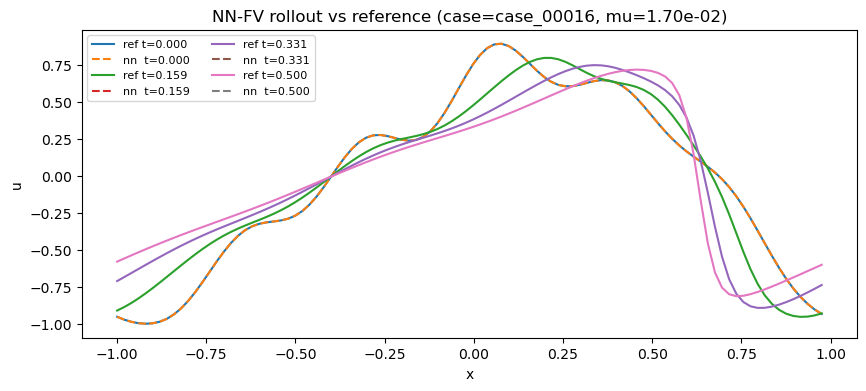

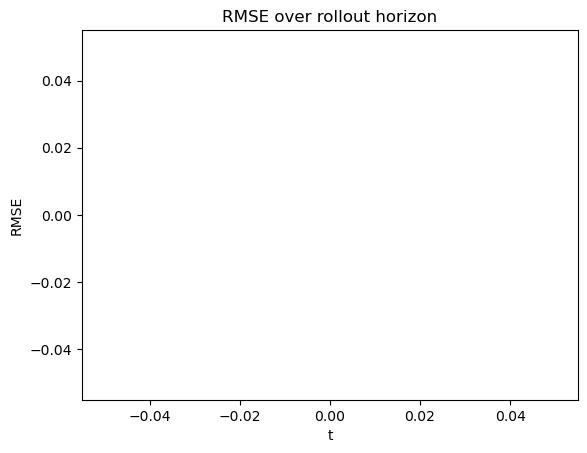

In [37]:
def rollout_predict(u0_np, dt, dx, mu, model, steps=50):
    u = tf.convert_to_tensor(u0_np, tf.float32)
    traj = [u.numpy()]
    for _ in range(steps):
        u = ssp_rk3_step_tf(u, tf.constant(dt, tf.float32), tf.constant(dx, tf.float32),
                            tf.constant(mu, tf.float32), model)
        traj.append(u.numpy())
    return np.stack(traj, axis=0)

# pick a case and time
data = cases[16]
U = data["U"]
times = data["times"]
mu = float(data["mu"])
dx = float(data["dx"])

n0 = 0
steps = min(60, U.shape[0]-n0-1)
dt = float(times[n0+1] - times[n0])

pred = rollout_predict(U[n0], dt, dx, mu, model, steps=steps)
ref = U[n0:n0+steps+1]

x = data["x"]

# Plot snapshots
plt.figure(figsize=(10,4))
for k in [0, steps//3, 2*steps//3, steps]:
    plt.plot(x, ref[k], label=f"ref t={times[n0+k]:.3f}")
    plt.plot(x, pred[k], linestyle="--", label=f"nn  t={times[n0+k]:.3f}")
plt.title(f"NN-FV rollout vs reference (case={data['name']}, mu={mu:.2e})")
plt.xlabel("x"); plt.ylabel("u")
plt.legend(fontsize=8, ncol=2)
plt.show()

# Error over time
err = np.sqrt(np.mean((pred - ref)**2, axis=1))
plt.figure()
plt.plot(times[n0:n0+steps+1], err)
plt.title("RMSE over rollout horizon")
plt.xlabel("t"); plt.ylabel("RMSE")
plt.show()
